In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../..")

In [3]:
import omegaconf
from shell.utils.experiment_utils import *
from shell.fleet.utils.fleet_utils import *
from shell.utils.metric import *
import matplotlib.pyplot as plt
from shell.fleet.network import TopologyGenerator
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
from shell.fleet.fleet import Agent, Fleet
from shell.fleet.data.data_utilize import *
from shell.fleet.data.recv import *

from sklearn.manifold import TSNE
from torchvision.utils import make_grid
from shell.fleet.data.data_utilize import *
import logging
from sklearn.metrics import f1_score
import os
from shell.fleet.data.recv_utils import *
from tqdm import tqdm
import argparse
from functools import partial
from torchvision.utils import make_grid
from shell.utils.oodloss import OODSeparationLoss
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.zscore import ZSCORE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import defaultdict

logging.basicConfig(level=logging.INFO)

In [4]:
dataset = "mnist"
algo = "modular"

experiment_folder = "experiment_results"
experiment_name = "vanilla_fix_bug_compute_loss_encodev2"

use_contrastive = True
num_trains_per_class = 64
seed = 0
num_tasks = 10
parallel = False
comm_freq = 2 # "None" means no communication, doesn't matter for this analysis


save_dir = get_save_dir(experiment_folder, experiment_name,
                        dataset, algo, num_trains_per_class, use_contrastive, seed)
graph, datasets, NetCls, LearnerCls, net_cfg, agent_cfg, train_cfg, fleet_additional_cfg, cfg = get_cfg(
    save_dir)

module_selection_strategy = 'gt_most_similar'

cfg.sharing_strategy = DictConfig({
    "name": "modmod",
    'num_coms_per_round': 2,
    'module_selection': module_selection_strategy,
    'sync_base': False,
})

INFO:root:Class sequence: [5 0 4 3 4 6 4 3 8 0 1 0 5 9 6 4 9 0 3 0]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)


{'train': {'component_update_freq': 100, 'num_epochs': 100, 'init_component_update_freq': 100, 'init_num_epochs': 100, 'save_freq': 20}, 'dataset': {'dataset_name': 'mnist', 'num_tasks': 10, 'num_classes_per_task': 2, 'with_replacement': True, 'num_trains_per_class': 64, 'num_vals_per_class': 50, 'remap_labels': True}, 'net': {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0}, 'sharing_strategy': {'name': 'no_sharing', 'num_coms_per_round': 0}, 'seed': 0, 'algo': 'modular', 'job_name': 'mnist_modular_numtrain_64_contrastive', 'num_agents': 8, 'root_save_dir': 'experiment_results/vanilla_fix_bug_compute_loss_encodev2', 'parallel': True, 'num_init_tasks': 4, 'agent': {'save_dir': '${root_save_dir}/${job_name}/${dataset.dataset_name}/${algo}/seed_${seed}', 'batch_size': 64, 'memory_size': 32, 'improvement_threshold': 0.05, 'use_contrastive': True}}


INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [4 7 5 7 6 0 3 0 5 0 3 6 2 7 6 7 6 1 0 5]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 1, 28, 28)
INFO:root:Class sequence: [6 7 7 8 4 1 1 8 6 1 6 4 5 7 8 0 2 3 0 3]
INFO:root:task 0 :(128, 1, 28, 28)
INFO:root:task 1 :(128, 1, 28, 28)
INFO:root:task 2 :(128, 1, 28, 28)
INFO:root:task 3 :(128, 1, 28, 28)
INFO:root:task 4 :(128, 1, 28, 28)
INFO:root:task 5 :(128, 1, 28, 28)
INFO:root:task 6 :(128, 1, 28, 28)
INFO:root:task 7 :(128, 1, 28, 28)
INFO:root:task 8 :(128, 1, 28, 28)
INFO:root:task 9 :(128, 

i_size 28
num_classes 2
net_cfg {'name': 'mlp', 'depth': 4, 'layer_size': 64, 'dropout': 0.0, 'i_size': 28, 'num_classes': 2, 'num_tasks': 10, 'num_init_tasks': 4, 'use_contrastive': True}
<class 'shell.learners.er_dynamic.CompositionalDynamicER'>


In [5]:
AgentCls = get_agent_cls(cfg.sharing_strategy, cfg.algo, parallel)
FleetCls = get_fleet(cfg.sharing_strategy, parallel)

In [6]:
def setup_fleet(task_id=None): 
    fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)
    if task_id is not None:
        fleet.load_model_from_ckpoint(task_ids=task_id)
    return fleet

def add_random_module(receiver, task_id, check=True):
    if check and len(receiver.net.candidate_indices) != 0:
        return
    receiver.net.add_tmp_modules(task_id, num_modules=1)

def transfer_module(receiver, sender, task_id, check=True):
    new_module = sender.net.components[-1]
    add_random_module(receiver, task_id, check=check)
    receiver.net.receive_modules(task_id, [new_module])

def transfer_decoder(receiver, sender, rcv_task_id, sender_task_id=None):
    if sender_task_id is None:
        sender_task_id = rcv_task_id
    receiver.net.decoder[rcv_task_id].load_state_dict(sender.net.decoder[sender_task_id].state_dict())

@torch.no_grad()
def transfer_structure(receiver, sender, task_id):
    target = receiver.net.structure[task_id]
    source = sender.net.structure[task_id]
    if target.shape == source.shape:
        target.copy_(source)

In [7]:
def run_counterfactual_scenario(scenario, task_id=None, agent_id=None):
    total_results = defaultdict(dict)
    task_ids = range(cfg.num_init_tasks, num_tasks) if task_id is None else [task_id]
    agent_ids = range(len(setup_fleet().agents)) if agent_id is None else [agent_id]

    for t_id in task_ids:
        print('task', t_id)
        target_fleet = setup_fleet(t_id-1)
        source_fleet = setup_fleet(t_id)
        for a_id in agent_ids:
            print('a_id', a_id)
            target_agent = target_fleet.agents[a_id]
            source_agent = source_fleet.agents[a_id] 

            results = {'Raw': None, 'Transfer Decoder': None, 'Decoder + Structure': None}

            if scenario == "no new module":
                pass
            elif scenario == "optimized module":
                transfer_module(target_agent, source_agent, t_id)
            elif scenario == "random module":
                add_random_module(target_agent, t_id)

            results['Raw'] = target_agent.eval_test(t_id)
            
            transfer_decoder(target_agent, source_agent, t_id)
            results['Transfer Decoder'] = target_agent.eval_test(t_id)

            transfer_structure(target_agent, source_agent, t_id)
            results['Decoder + Structure'] = target_agent.eval_test(t_id)

            total_results[t_id][a_id] = results

    return total_results


In [8]:
def run_opt_module_struct(scenario, target_agent, source_agent, task_id, train_candidate_module=True):
    if "optimized_module" in scenario:
        transfer_module(target_agent, source_agent, task_id)
        train_candidate_module = False if "frozen" in scenario else True
    elif scenario == "random_module":
        add_random_module(target_agent, task_id)
        train_candidate_module = True
    else:
        raise NotImplementedError

    target_agent.agent.T = task_id
    target_agent.update_replay_buffer(task_id-1)
    target_agent.agent.change_save_dir(target_agent.agent.save_dir.replace(experiment_name, experiment_name + "_modmod_eng_" + scenario))
    # opt the last component
    # target_agent.net.active_candidate_index = target_agent.net.num_components-1
    # target_agent.net.candidate_indices = [target_agent.net.num_components-1]
    # print(target_agent.net.candidate_indices, target_agent.net.active_candidate_index)

    target_agent.train(task_id, train_candidate_module=train_candidate_module,
                       save_freq=10,
                       num_candidate_modules=0,)
    return target_agent

In [9]:
def run_training_scenario(scenario, task_id, agent_id):
    target_fleet = setup_fleet(task_id-1)
    target_agent = target_fleet.agents[agent_id]

    source_fleet = setup_fleet(task_id)
    source_agent = source_fleet.agents[agent_id] 
    return run_opt_module_struct(scenario, target_agent, source_agent, task_id)

In [10]:
def run_learning_speed_scenario(scenario, source_agent_id, target_agent_id,
                                source_task, target_task):
    fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                        LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                        train_kwargs=train_cfg, **fleet_additional_cfg)
    source_agent = fleet.agents[source_agent_id]
    target_agent = fleet.agents[target_agent_id]

    source_agent.load_model_from_ckpoint(task_id=source_task)
    target_agent.load_model_from_ckpoint(task_id=target_task-1)
    return run_opt_module_struct(scenario, target_agent, source_agent, target_task)

## Counterfactual
Same exact model

### Zero-shot Transfer

In [11]:

def plot_performance(res):
    categories = ['Raw', 'Transfer Decoder', 'Decoder + Structure']
    task_ids = sorted(res.keys())
    means = {category: [] for category in categories}
    stds = {category: [] for category in categories}

    for t_id in task_ids:
        for category in categories:
            scores = [res[t_id][a_id][category][t_id] for a_id in res[t_id]]
            means[category].append(np.mean(scores))
            stds[category].append(np.std(scores))

    plt.figure(figsize=(10, 6))
    for category in categories:
        mean_scores = means[category]
        std_scores = stds[category]
        plt.plot(task_ids, mean_scores, label=category)
        plt.fill_between(task_ids, np.subtract(mean_scores, std_scores), np.add(mean_scores, std_scores), alpha=0.2)

    plt.xlabel('Task ID')
    plt.ylabel('Average Performance')
    plt.legend()
    plt.grid(True)
    plt.show()


In [12]:
res = run_counterfactual_scenario("no new module")

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: 

task 4
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 5
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 6
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 7
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 8
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 9
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


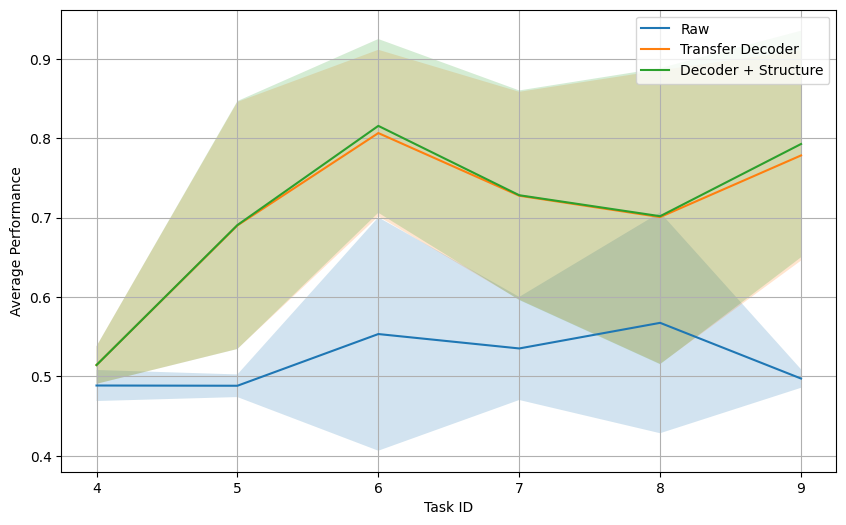

In [13]:
plot_performance(res)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: 

task 4
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 5
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 6
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 7
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 8
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 9
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


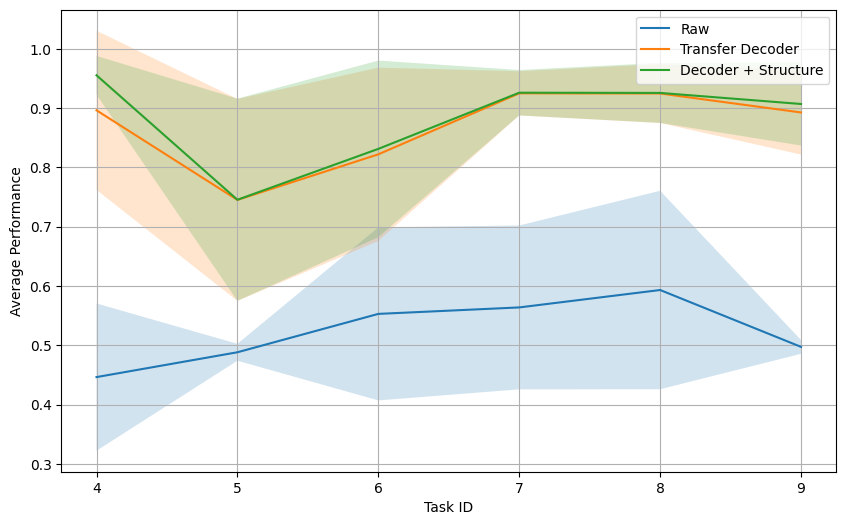

In [14]:
res = run_counterfactual_scenario("optimized module")
plot_performance(res)

In [15]:
res = run_counterfactual_scenario("random module")
plot_performance(res)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: 

task 4
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 5
a_id 0
a_id 1
a_id 2
a_id 3
a_id 4
a_id 5
a_id 6
a_id 7


INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


task 6
a_id 0
a_id 1
a_id 2
a_id 3


KeyboardInterrupt: 

### Learning speed
Only transfer the module. Receiver optimized the structure and decoder on its own.

In [16]:
target_agent = run_training_scenario("optimized_module_frozen", task_id=4, agent_id=0)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


ConfigAttributeError: Missing key opt_with_random
    full_key: sharing_strategy.opt_with_random
    object_type=dict

In [17]:
random_module_target_agent = run_training_scenario("random_module", task_id=4, agent_id=0)

INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized
INFO:root:Agent: node_id: 0, seed: 0
INFO:root:Agent: node_id: 1, seed: 1000
INFO:root:Agent: node_id: 2, seed: 2000
INFO:root:Agent: node_id: 3, seed: 3000
INFO:root:Agent: node_id: 4, seed: 4000
INFO:root:Agent: node_id: 5, seed: 5000
INFO:root:Agent: node_id: 6, seed: 6000
INFO:root:Agent: node_id: 7, seed: 7000
INFO:root:Created fleet with 8 agents
INFO:root:Adding neighbors...
INFO:root:Fleet initialized


ConfigAttributeError: Missing key opt_with_random
    full_key: sharing_strategy.opt_with_random
    object_type=dict

In [ ]:
unfrozen_target_agent = run_training_scenario("optimized_module", task_id=4, agent_id=0)

In [ ]:
df = target_agent.agent.record.df
unfrozen_df = unfrozen_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

In [ ]:
# plot test_task with epoch
test_task = 4
fig, ax = plt.subplots()
df[df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

## Task Similarity between neighbors

In [ ]:
fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)

In [ ]:
source_agent_id, target_agent_id = 0, 2
source_task, target_task = 4, 7
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]

In [ ]:
fleet.load_records()
fleet.load_model_from_ckpoint(task_ids=target_task)

In [ ]:
fleet.communicate_round(target_task, end_epoch=-1, comm_freq=-1, num_epochs=-1,
                        communication_round=0)

In [ ]:
for agent in fleet.agents:
    print(agent.dataset.class_sequence[:(target_task + 1)* agent.dataset.num_classes_per_task])

In [ ]:
fleet.communicate_round(target_task, end_epoch=-1, comm_freq=-1, num_epochs=-1,
                        communication_round=1)

In [ ]:
target_agent.incoming_modules

In [ ]:
target_agent.train_kwargs

In [ ]:
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

In [ ]:

add_modules_record = os.path.join(
    source_agent.save_dir, "add_modules_record.csv")
df = pd.read_csv(add_modules_record)
df

In [ ]:

add_modules_record = os.path.join(
    target_agent.save_dir, "add_modules_record.csv")
df = pd.read_csv(add_modules_record)
df

In [ ]:
source_agent.load_model_from_ckpoint(task_id=source_task)
target_agent.load_model_from_ckpoint(task_id=target_task-1)

In [ ]:
target_agent.eval_test(target_task)

In [ ]:
# transfer_decoder(target_agent, source_agent, target_task, source_task)
# target_agent.eval_test(target_task)
'''
{0: 0.9615384615384616,
 1: 0.9839357429718876,
 2: 0.9695876288659794,
 3: 0.9809236947791165,
 4: 0.4984646878198567,
 'avg': 0.8788900431950604}
 '''

In [ ]:
# transfer_module(target_agent, source_agent, target_task)
# target_agent.eval_test(target_task)
'''
{0: 0.9615384615384616,
 1: 0.9839357429718876,
 2: 0.9695876288659794,
 3: 0.9809236947791165,
 4: 0.4984646878198567,
 'avg': 0.8788900431950604}
 '''

In [ ]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)

In [ ]:
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)

In [ ]:
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)

In [ ]:
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

In [ ]:
frozen_mod_target_agent.agent.record.df

In [ ]:
# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

Two tasks have something in common but not completely identical

In [ ]:
source_agent_id, target_agent_id = 1, 0
source_task, target_task = 4, 4
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

In [ ]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

Source and target tasks have nothing in common

In [ ]:
source_agent_id, target_agent_id = 2, 0
source_task, target_task = 4, 4
source_agent = fleet.agents[source_agent_id]
target_agent = fleet.agents[target_agent_id]
# make sure that they have the same tasks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(make_grid(source_agent.dataset.trainset[source_task].tensors[0]).permute(1, 2, 0))
ax[1].imshow(make_grid(target_agent.dataset.trainset[target_task].tensors[0]).permute(1, 2, 0))

In [ ]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id, target_agent_id,
                                source_task, target_task)
unfrozen_mod_target_agent = run_learning_speed_scenario("optimized_module", source_agent_id, target_agent_id,
                                source_task, target_task)
frozen_mod_target_agent = run_learning_speed_scenario("optimized_module_frozen", source_agent_id, target_agent_id,
                                source_task, target_task)
df = frozen_mod_target_agent.agent.record.df
unfrozen_df = unfrozen_mod_target_agent.agent.record.df
random_module_df = random_module_target_agent.agent.record.df

# plot test_task with epoch
fig, ax = plt.subplots()
df[df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
unfrozen_df[unfrozen_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                               label="Unfrozen",
                                                                                                               marker='o')

random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);

Competition between two modules

In [ ]:
def compute_task_sim(cls_seq1, cls_seq2, task_id1, task_id2, 
                     num_classes_per_task=2):
    task_cls1 = cls_seq1[task_id1 * num_classes_per_task: (task_id1 + 1) * num_classes_per_task]
    task_cls2 = cls_seq2[task_id2 * num_classes_per_task: (task_id2 + 1) * num_classes_per_task]
    return len(set(task_cls1).intersection(set(task_cls2))), task_cls1, task_cls2

In [ ]:
fleet = FleetCls(graph, cfg.seed, datasets, cfg.sharing_strategy, AgentCls, NetCls=NetCls,
                    LearnerCls=LearnerCls, net_kwargs=net_cfg, agent_kwargs=agent_cfg,
                    train_kwargs=train_cfg, **fleet_additional_cfg)

source_agent_id1, source_agent_id2, target_agent_id = 2, 1, 0
source_task1, source_task2, target_task = 7, 4, 4

source_agent1 = fleet.agents[source_agent_id1]
source_agent2 = fleet.agents[source_agent_id2]
target_agent = fleet.agents[target_agent_id]

print(compute_task_sim(source_agent1.dataset.class_sequence, target_agent.dataset.class_sequence, source_task1, target_task))
print(compute_task_sim(source_agent2.dataset.class_sequence, target_agent.dataset.class_sequence, source_task2, target_task))

In [ ]:
source_agent1.load_model_from_ckpoint(task_id=source_task1)
source_agent2.load_model_from_ckpoint(task_id=source_task2)
target_agent.load_model_from_ckpoint(task_id=target_task-1)

# transfer_module(target_agent, source_agent1, target_task, check=False)
# transfer_module(target_agent, source_agent2, target_task, check=False)

module1 = source_agent1.net.components[-1]
module2 = source_agent2.net.components[-1]

target_agent.net.add_tmp_modules(target_task, num_modules=2)
target_agent.net.receive_modules(target_task, [module1, module2])

In [ ]:
print(len(target_agent.net.components))
print(target_agent.net.candidate_indices)

In [ ]:
target_agent.eval_test(target_task)

In [ ]:
target_agent.agent.T = target_task
target_agent.update_replay_buffer(target_task-1)
target_agent.agent.change_save_dir(target_agent.agent.save_dir.replace(experiment_name, experiment_name + "_modmod_eng_" + "two_mods"))


In [ ]:
target_agent.save_dir

In [ ]:
target_agent.train(target_task, train_candidate_module=True,
                       save_freq=10,
                       num_candidate_modules=0,)

In [ ]:
random_module_target_agent = run_learning_speed_scenario("random_module", source_agent_id1, target_agent_id,
                                source_task1, target_task)
random_module_df = random_module_target_agent.agent.record.df

In [ ]:
df = target_agent.agent.record.df
test_task = target_task
fig, ax = plt.subplots()
df[df['test_task'] == test_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax, label="Frozen",
                                                                                             marker='o')
random_module_df[random_module_df['test_task'] == target_task].groupby(['epoch']).mean(numeric_only=True)['test_acc'].plot(ax=ax,
                                                                                                                label="Random",
                                                                                                                marker='o')                                                                                             
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")
ax.legend()
ax.set_ylim(0.2, 1);